In [1]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
import numpy as np

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import style

In [3]:
from __future__ import division, print_function

import os
import numpy as np

from astropy import units as u
from astropy import constants as cnst
from astropy.coordinates import SkyCoord, Distance
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astropy.table import Table

# LG 

In [143]:
#special import magic w/ cding
pwd = os.path.abspath(os.curdir)
os.chdir(os.environ['HOME']+'/astrodata/mcconn12_nearbydwarfs/')
import nearbygals
ngtab = nearbygals.get_table()
os.chdir(pwd)

In [144]:
ng_MV = ngtab['Vmag'] - ngtab['distmod']#-3.1*ngtab['EBmV']

#fix LMC/SMC manually
#ng_MV[ngtab['name']=='LMC'] =  
#ng_MV[ngtab['name']=='LMC'] = 

#MV -> Mr: assuming "typcial" B-V=1 and Jester for Stars with Rc-Ic < 1.15 and U-B < 0
BmV = 1
ng_Mr = ng_MV - 0.46*(BmV) + 0.11

Mr_MW_sats = ng_Mr[(20 < ngtab['distance'])&(ngtab['distance'] < 300)]

Anddist = ngtab[ngtab['and_number']==0]['center'][0].separation_3d(SkyCoord(ra=[row.ra for row in ngtab['center']], 
         dec=[row.dec for row in ngtab['center']], 
         distance=[row.distance for row in ngtab['center']]))
Mr_And_sats = ng_Mr[Anddist < 300*u.kpc][1:]  #First one is actually M31

# Full data set

In [40]:
allspec = Table.read(os.environ['HOME']+'/Dropbox/SAGA/data/allspectaken_v4.fits')
allsats = allspec[(allspec['SATS']==1)&(allspec['REMOVE']==-1)]
allsats

objID,ra,dec,phot_sg,flags,specObjID,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,Au,Ag,Ar,Ai,Az,fibermag_r,fiber2mag_r,expRad_r,sb_exp_r,petroR50_r,petroR90_r,petroMag_r,sb_petro_r,J,Jerr,H,Herr,K,Kerr,w1,w1err,w2,w2err,spec_z,spec_z_err,spec_z_warn,photoz,photoz_err,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,PCLASS_1,SATS,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_REPEAT
int64,float64,float64,int16,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float64,float64,float64,int64,int64,str48,float64,float64,int64,int64,int64,int64,str4,str48,float64,str48
1237648702984683605,225.005401226,-1.09130226734,3,1161121054724696,1038170464519743488,16.0251,15.3274,15.0087,14.9003,14.7838,0.00790307,0.00274512,0.00320407,0.00445661,0.00904204,0.327712,0.241128,0.174886,0.132611,0.0940226,17.9322,18.7455,-99.0,-99.0,6.35402,15.5154,-99.0,20.980901535,16.079,0.2,14.286,9999.0,14.022,9999.0,12.5717,0.00404706,13.452,0.031,0.00629765,5.12096e-06,0,0.052463,0.042043,224.594,-1.09102,28.4038,1922.0,7.693,145729,0,,24.6830184051,203.937503578,35574,-1,1,-1,NSA,sdss,4.0,SDSS
1237650372092690464,180.29544216,-1.2976838319,3,1319448581640280,0,14.7189,13.8689,13.5233,13.3643,13.3112,0.00616112,0.00218275,0.00221878,0.00297785,0.00571236,0.18759,0.138027,0.100109,0.0759093,0.0538207,18.1215,18.8384,-99.0,-99.0,16.2607,36.7104,-99.0,21.3926642507,16.481,0.203,14.687,9999.0,14.353,9999.0,13.57,0.032,13.415,0.042,0.00496344,-1.0,0,0.03922,0.037245,180.098,-1.10008,23.2487,1465.0,7.321,140594,0,Alice,16.7329983482,113.161017531,171514,-1,1,-1,NSA,sixdf,4.0,
1237662524159557759,195.103918476,13.6702528117,3,263951778713872,1993991333693384704,16.2941,15.3909,15.0711,14.9532,14.9347,0.0227312,0.00667544,0.0117505,0.0181898,0.0299357,0.182322,0.134151,0.0972974,0.0737777,0.0523093,19.5029,20.3731,-99.0,-99.0,11.7887,31.5461,-99.0,22.1488131629,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,14.931,0.04,14.662,0.071,0.00670154,1.43393e-05,0,0.02964,0.021994,194.863,14.1712,30.027,1988.0,7.907,142722,0,,33.1822246225,289.825648558,75784,-1,1,-1,NSA,sdss,4.0,SDSS
1237662525233037420,194.572104136,14.5571518823,3,1161189774200920,1994022669774776320,15.0794,13.9057,13.3422,13.0646,12.8458,0.00876489,0.00258233,0.00253072,0.00278083,0.00790994,0.138485,0.101896,0.0739036,0.0560389,0.0397323,18.0356,18.8593,-99.0,-99.0,22.4107,63.5675,-99.0,21.8393358194,15.688,0.138,15.075,0.166,14.543,0.125,10.978,0.00166256,13.465,0.062,0.00674294,1.85704e-05,0,0.044988,0.01468,194.863,14.1712,30.027,1988.0,7.907,142722,0,,28.678557215,250.4899595,169964,-1,1,-1,NSA,sdss,4.0,SDSS
1237662196143947955,206.062030556,41.6773969113,3,35253360136464,1550476098200954880,17.5703,16.3626,15.7229,15.4422,15.4075,0.0357736,0.00551178,0.00491173,0.0056155,0.0156972,0.0372117,0.02738,0.0198583,0.0150579,0.0106763,18.7425,19.4958,-99.0,-99.0,6.86541,23.2344,-99.0,21.817637634,16.626,0.129,15.818,0.131,15.683,0.189,13.8742,0.00752922,14.749,0.05,0.00869595,9.33515e-06,0,0.055504,0.026538,206.33,41.7125,37.2285,2549.01,8.434,163956,0,,12.1863238779,131.9694668,56424,-1,1,-1,NSA,sdss,4.0,SDSS
1237662307796910232,206.19066673,41.5567177,3,475058011246640,1550486543561418752,18.255,17.0938,16.5442,16.2924,16.1036,0.0368874,0.00637697,0.00590459,0.00811227,0.0274015,0.0439143,0.0323118,0.0234352,0.0177702,0.0125993,19.298,20.0954,-99.0,-99.0,5.57039,13.9169,-99.0,22.19578327,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,14.2203,0.010956,15.078,0.061,0.00894533,2.04436e-05,0,0.048505,0.029693,206.33,41.7125,37.2285,2549.01,8.434,163956,0,,11.2416329592,121.739154933,56427,-1,1,-1,NSA,sdss,4.0,SDSS
1237662300829384713,228.771613868,42.2094568926,3,1178711093284952,188934

(array([ 0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.,  27.,  30.]),
 <a list of 10 Patch objects>)

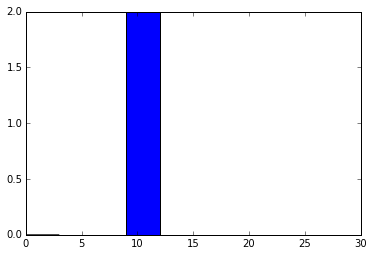

In [44]:
#double-check that there's no very close pairs/repeats
allsatcoords = SkyCoord(allsats['ra'], allsats['dec'], unit=u.deg)
idx, d2d, d3d = allsatcoords.match_to_catalog_sky(allsatcoords, nthneighbor=2)
plt.hist(d2d.arcsec,range=(0,30))

In [55]:
nametoids = dict(zip(allsats['HOST_SAGA_NAME'], allsats['HOST_NSAID']))
del nametoids['']
nametoids

{'Aeneid': 148734,
 'Alice': 140594,
 'AnaK': 61945,
 'Beowulf': 135667,
 'Dune': 165536,
 'Gilgamesh': 166313,
 'Hamlet': 166035,
 'Iliad': 150238,
 'MobyDick': 85746,
 'OBrother': 149781,
 'Odyssey': 147100,
 'StarTrek': 33446,
 'Ulysses': 150340}

In [162]:
def vals_to_steps(vals, lower, upper, reverse=False):
    svals = np.sort(vals)[::-1] if reverse else np.sort(vals)
    vsr = np.repeat(svals, 2)
    ns = np.repeat(np.arange(len(vals) + 1), 2)[1:-1]
    vsr = np.insert(vsr, 0, lower if reverse else upper)
    vsr = np.append(vsr, upper if reverse else lower)
    ns = np.insert(ns, [0, -1], [0, ns[-1]])
    return vsr, ns

In [230]:
#minus sign means low enough not to put on the plot below
completeness = {'Odyssey':.82, 
                'Gilgamesh':.78,
                'AnaK':.76,
                'StarTrek':.84,
                'MobyDick':.58,
                'Narnia':.52,
                'Dune':.74,
                'OBrother':.69,
                'Alice':-.14,
                'Sopranos':-.08,
                'Aeneid':.78,
                'Beowulf':-.14,
                'Hamlet':.35}

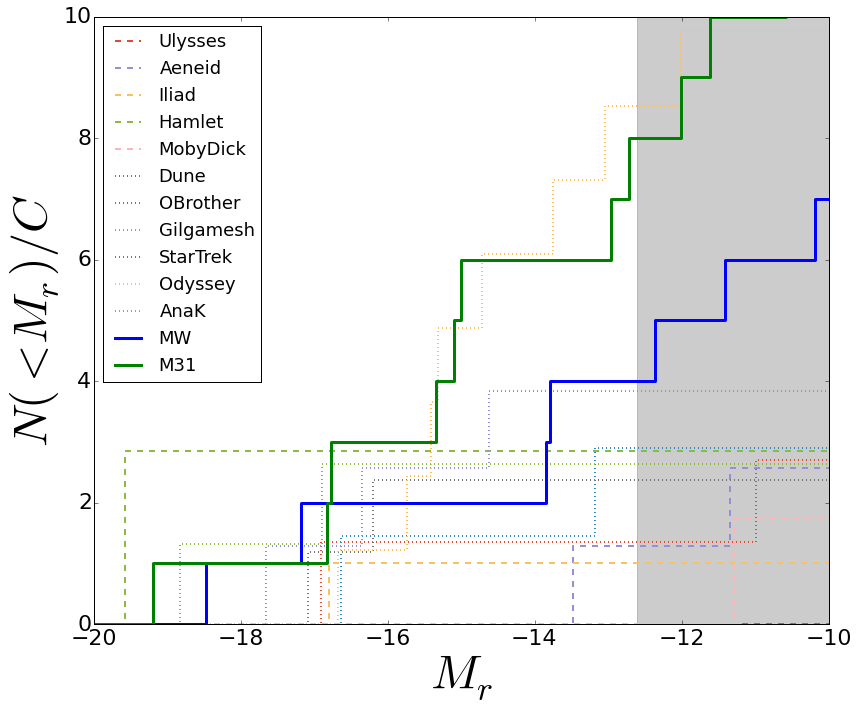

In [231]:
plt.figure(figsize=(12,10))
lower, upper = -10, -20

plot_styles = []
color_cycle = style.library['ggplot']['axes.color_cycle']
for line_style in ['--', ':']:
    for c in color_cycle:
        plot_styles.append(dict(color=c, ls=line_style))
    

for i, (nm, nsaid) in enumerate(nametoids.items()):
    msk = allsats['HOST_NSAID'] == nsaid
    satsofhost = allsats[msk]
    dm = Distance(satsofhost['HOST_DIST'], u.Mpc).distmod.value
    Mr = satsofhost['r'] + satsofhost['Ar'] - dm
    
    compl = completeness.get(nm, 1)
    if compl<0:
        continue
    vals, ns = vals_to_steps(Mr, lower, upper)
    plt.plot(vals, ns/compl, lw=2, label=nm, **plot_styles[i])
    
    
plt.plot(*vals_to_steps(Mr_MW_sats, lower, upper), label='MW', ls='-', lw=3)
plt.plot(*vals_to_steps(Mr_And_sats, lower, upper), label='M31', ls='-', lw=3)


incomplmag = 20.5*u.mag - Distance(42*u.Mpc).distmod
plt.axvspan(lower, incomplmag.value, alpha=.2,color='k')

plt.xlim(upper, lower)
plt.ylim(0, 10.)
plt.legend(loc=0, fontsize=18)

plt.xlabel(r'$M_r$', fontsize=48)
plt.ylabel(r'$N(<M_r)/C$', fontsize=48)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.savefig('SAGA_LF.png')
plt.savefig('SAGA_LF.pdf')

# Odyssey/Gilgamesh only

In [3]:
sattab = fits.getdata('/Users/erik/Dropbox/SAGA/satellite-learning/galaxies_around_SAGAhosts_allspectra_v2.3.fits.gz')

In [21]:
issat = sattab['SATS']==1
inody = sattab['HOSTNAME']=='Odyssey'
ingilg = sattab['HOSTNAME']=='Gilgamesh'
odysats = sattab[issat&inody]
gilgsats = sattab[issat&ingilg]
len(odysats), len(gilgsats)

(8, 2)

In [206]:
odysats[-2][1]

(1237662224092299404, 247.84002994962782, 20.184075813520494, 3, 105553418387472, 0, 14.96636, 13.900308, 13.309114, 13.030106, 12.79305, 0.14956565, 0.0, 0.0, 0.0, 0.20462532, 0.32571051, 0.23965468, 0.17381756, 0.13180059, 0.093448266, 18.629335, 19.469557, 26.837091, 22.448240280151367, 16.462582, 40.518742, 14.738416, 22.816354751586914, 9999.0, 9999.0, 9999.0, 9999.0, 9999.0, 9999.0, 9999.0, 9999.0, 9999.0, 9999.0, 0.0085534714, -1.0, 0, 0.097627997, 0.099662997, 68560, '147100', '      248.087', 19.826429, 2375.0, 34.0, 25.598127615297667, 253.16823706977448, 1, 'Odyssey', 'NSA', '', 4.0, 'NSA')

In [199]:
Mr_ody_sats = odysats['R'] - odysats['AR'] - Distance(odysats['HOST_DIST']*u.Mpc).distmod.value
Mr_gilg_sats = gilgsats['R'] - gilgsats['AR'] - Distance(gilgsats['HOST_DIST']*u.Mpc).distmod.value

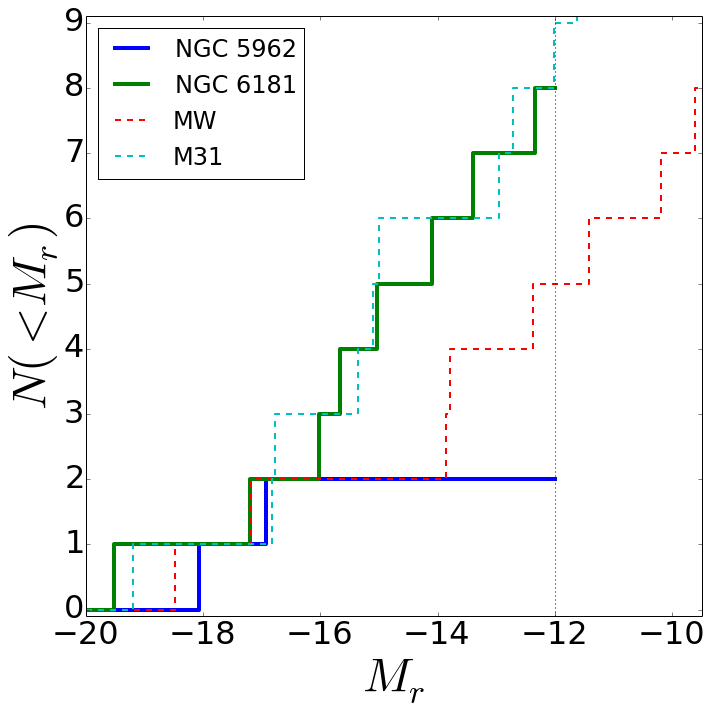

In [207]:
rcParams['xtick.labelsize'] = rcParams['ytick.labelsize'] = 16*2
rcParams['axes.labelsize'] = 24*2
rcParams['legend.fontsize'] = 24

def lumfunc(mag, startat=-20, extend_to=-12, **kwargs):
    kwargs.setdefault('where', 'pre')
    kwargs.setdefault('lw', 2)
    
    mags = np.sort(mag)
    Mr, n =  np.r_[mags, mags[-1]], np.arange(len(mags)+1)
    if extend_to and mags[-1] < extend_to:
        Mr = np.r_[Mr, extend_to]
        n = np.r_[n, n[-1]]
    if startat and mags[0] > startat:
        Mr = np.r_[startat, Mr]
        n = np.r_[0, n]
    return plt.step(Mr, n, **kwargs)

plt.figure(figsize=(10,10))
lumfunc(Mr_gilg_sats, label='NGC 5962', lw=4) 
lumfunc(Mr_ody_sats, label='NGC 6181', ls='-', lw=4)
lumfunc(Mr_MW_sats, label='MW', ls='--', lw=2)
lumfunc(Mr_And_sats, label='M31', ls='--', lw=2)

plt.axvline(-12, color='k', ls=':')

plt.xlim(-20,-9.5)
plt.ylim(-.1,9.1)
plt.yticks(np.arange(10))

magstr = 'M_r'
plt.xlabel('${magstr}$'.format(**locals()))
plt.ylabel('$N(<{magstr})$'.format(**locals()))

plt.legend(loc=0)


plt.tight_layout()

plt.savefig('/Users/erik/Desktop/aatprop_lumfunc.pdf')
plt.savefig('/Users/erik/Desktop/aatprop_lumfunc.eps')
plt.savefig('/Users/erik/Desktop/aatprop_lumfunc.png')